Using device: cpu
Epoch [1/30], Loss: 1.3629
Epoch [2/30], Loss: 0.9949
Epoch [3/30], Loss: 0.8611
Epoch [4/30], Loss: 0.7319
Epoch [5/30], Loss: 0.6944
Epoch [6/30], Loss: 0.6141
Epoch [7/30], Loss: 0.5568
Epoch [8/30], Loss: 0.5357
Epoch [9/30], Loss: 0.5141
Epoch [10/30], Loss: 0.4478
Epoch [11/30], Loss: 0.4063
Epoch [12/30], Loss: 0.3714
Epoch [13/30], Loss: 0.3724
Epoch [14/30], Loss: 0.3325
Epoch [15/30], Loss: 0.3269
Epoch [16/30], Loss: 0.2863
Epoch [17/30], Loss: 0.3054
Epoch [18/30], Loss: 0.4543
Epoch [19/30], Loss: 0.2817
Epoch [20/30], Loss: 0.2366
Epoch [21/30], Loss: 0.2293
Epoch [22/30], Loss: 0.2039
Epoch [23/30], Loss: 0.1972
Epoch [24/30], Loss: 0.2094
Epoch [25/30], Loss: 0.1896
Epoch [26/30], Loss: 0.1987
Epoch [27/30], Loss: 0.1771
Epoch [28/30], Loss: 0.1558
Epoch [29/30], Loss: 0.1544
Epoch [30/30], Loss: 0.1757


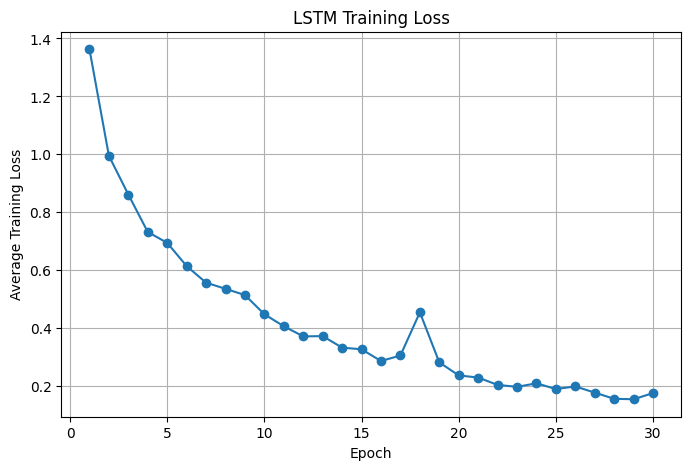

Test Accuracy: 0.9621


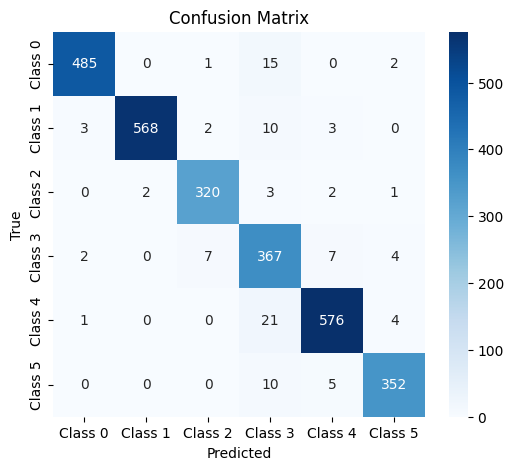


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       503
           1       1.00      0.97      0.98       586
           2       0.97      0.98      0.97       328
           3       0.86      0.95      0.90       387
           4       0.97      0.96      0.96       602
           5       0.97      0.96      0.96       367

    accuracy                           0.96      2773
   macro avg       0.96      0.96      0.96      2773
weighted avg       0.96      0.96      0.96      2773


Starte 5-Fold Stratified Cross-Validation...

Fold 1
Epoch [1/15], Loss: 1.3915
Epoch [2/15], Loss: 0.9855
Epoch [3/15], Loss: 0.8196
Epoch [4/15], Loss: 0.7598
Epoch [5/15], Loss: 0.6256
Epoch [6/15], Loss: 0.5886
Epoch [7/15], Loss: 0.6334
Epoch [8/15], Loss: 0.5009
Epoch [9/15], Loss: 0.4725
Epoch [10/15], Loss: 0.4458
Epoch [11/15], Loss: 0.3895
Epoch [12/15], Loss: 0.3755
Epoch [13/15], Loss: 0.3345
Epoch [14/15], Loss: 0.3

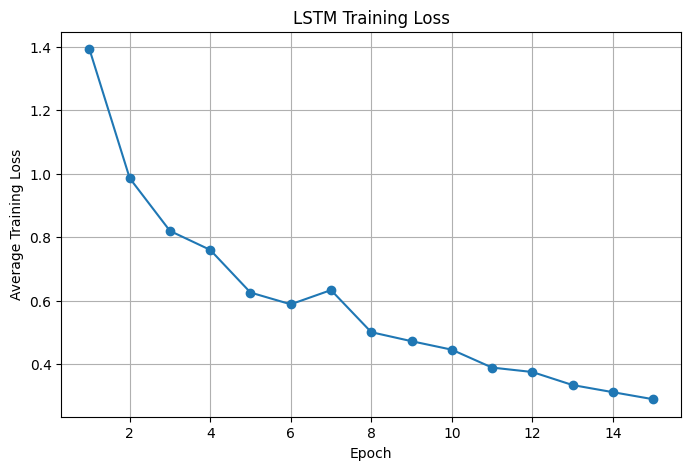

Test Accuracy: 0.8864

Fold 2
Epoch [1/15], Loss: 1.3617
Epoch [2/15], Loss: 1.0290
Epoch [3/15], Loss: 0.8867
Epoch [4/15], Loss: 0.7831
Epoch [5/15], Loss: 0.6966
Epoch [6/15], Loss: 0.5985
Epoch [7/15], Loss: 0.5166
Epoch [8/15], Loss: 0.4786
Epoch [9/15], Loss: 0.4364
Epoch [10/15], Loss: 0.3955
Epoch [11/15], Loss: 0.3687
Epoch [12/15], Loss: 0.3369
Epoch [13/15], Loss: 0.3276
Epoch [14/15], Loss: 0.2887
Epoch [15/15], Loss: 0.2893


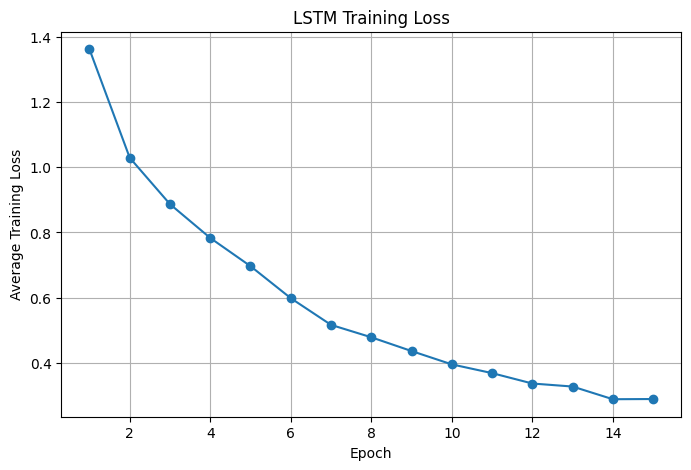

Test Accuracy: 0.8777

Fold 3
Epoch [1/15], Loss: 1.3960
Epoch [2/15], Loss: 1.0916
Epoch [3/15], Loss: 0.9340
Epoch [4/15], Loss: 0.8470
Epoch [5/15], Loss: 0.7610
Epoch [6/15], Loss: 0.6901
Epoch [7/15], Loss: 0.6373
Epoch [8/15], Loss: 0.5910
Epoch [9/15], Loss: 0.5416
Epoch [10/15], Loss: 0.4957
Epoch [11/15], Loss: 0.4813
Epoch [12/15], Loss: 0.4605
Epoch [13/15], Loss: 0.4125
Epoch [14/15], Loss: 0.4132
Epoch [15/15], Loss: 0.3491


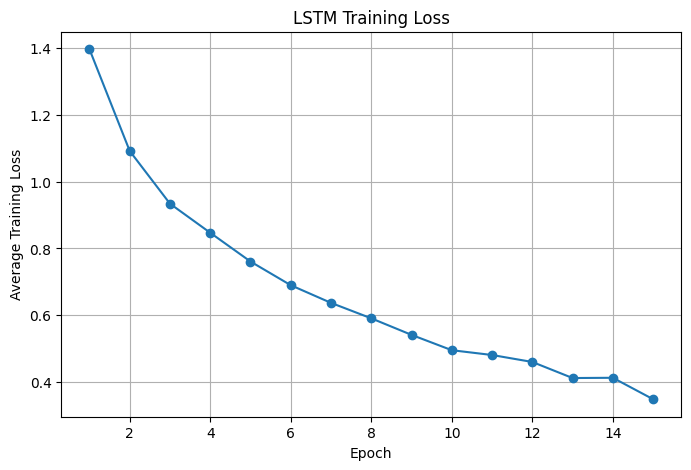

Test Accuracy: 0.9044

Fold 4
Epoch [1/15], Loss: 1.4098
Epoch [2/15], Loss: 1.0986


KeyboardInterrupt: 

In [1]:
# Importe
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from utils import load_dat_file
import matplotlib.pyplot as plt
import seaborn as sns
import glob

# =========================
# Dataset Klasse
# =========================
class GasSensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# =========================
# LSTM Modell Klasse
# =========================
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, lr=0.001):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

    def train_step(self, batch):
        self.optimizer.zero_grad()
        X_batch, y_batch = batch
        device = next(self.parameters()).device
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_model(self, train_loader, epochs):
        all_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for batch in train_loader:
                loss = self.train_step(batch)
                total_loss += loss
            avg_loss = total_loss / len(train_loader)
            all_losses.append(avg_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        plt.figure(figsize=(8,5))
        plt.plot(range(1, epochs+1), all_losses, marker='o')
        plt.xlabel("Epoch")
        plt.ylabel("Average Training Loss")
        plt.title("LSTM Training Loss")
        plt.grid(True)
        plt.show()
        return all_losses

    def evaluate(self, test_loader):
        self.eval()
        correct, total = 0, 0
        all_preds, all_labels = [], []
        device = next(self.parameters()).device
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = self(X_batch)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.4f}")
        self.train()
        return accuracy, all_labels, all_preds

    def save_model(self,path):
        torch.save(self.state_dict(), path)

    def load_model(self, path, map_location=None):
        self.load_state_dict(torch.load(path, map_location=map_location))

# =========================
# Helper Funktionen
# =========================
def create_sequences(X, y, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(xs), np.array(ys)

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

# =========================
# Daten einlesen: alle 10 Batches
# =========================
all_files = sorted(glob.glob("gas+sensor+array+drift+dataset/Dataset/batch*.dat"))
dfs = [load_dat_file(f) for f in all_files]
df_all = pd.concat(dfs, ignore_index=True)

X = df_all.iloc[:, 0:128].values
y = df_all.iloc[:, 128].values

# Normalisieren
scaler = MinMaxScaler(feature_range=(-1,1))
X = scaler.fit_transform(X)

# =========================
# Sequenzen erstellen
# =========================
SEQ_LEN = 50
X_seq, y_seq = create_sequences(X, y-1, SEQ_LEN)  # Labels 0-basiert

# =========================
# Train/Test Split (optional)
# =========================
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

train_dataset = GasSensorDataset(X_train_seq, y_train_seq)
test_dataset = GasSensorDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# =========================
# Training
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005).to(device)
model.train_model(train_loader, epochs=30)

acc, y_true, y_pred = model.evaluate(test_loader)
plot_confusion_matrix(y_true, y_pred, classes=[f"Class {i}" for i in range(6)])
model.save_model("lstm_all_batches.pth")

# =========================
# 5-Fold Stratified Cross-Validation
# =========================
print("\nStarte 5-Fold Stratified Cross-Validation...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq, y_seq)):
    print(f"\nFold {fold+1}")
    X_train_cv, X_val_cv = X_seq[train_idx], X_seq[val_idx]
    y_train_cv, y_val_cv = y_seq[train_idx], y_seq[val_idx]

    train_dataset = GasSensorDataset(X_train_cv, y_train_cv)
    val_dataset = GasSensorDataset(X_val_cv, y_val_cv)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    model_cv = LSTM(input_size=128, hidden_size=64, num_layers=1, num_classes=6, lr=0.0005).to(device)
    model_cv.train_model(train_loader, epochs=15)
    acc, _, _ = model_cv.evaluate(val_loader)
    accuracies.append(acc)

# Ergebnisse anzeigen
results = pd.DataFrame({"Fold": list(range(1, 6)), "Accuracy": accuracies})
print("\nCross-Validation Ergebnisse:")
print(results)
print("Durchschnittliche Accuracy:", results["Accuracy"].mean())

plt.figure(figsize=(6,4))
plt.bar(results["Fold"], results["Accuracy"], color="skyblue")
plt.axhline(results["Accuracy"].mean(), color="red", linestyle="--", label="Durchschnitt")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy pro Fold")
plt.legend()
plt.show()
